In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
import sys

In [3]:
sys.path.insert(0, "/home/pleroy/DEV/processing/focalization_python")
from posarutils.other.PosarMCParameters import *

In [4]:
sys.path.insert(0, "/home/pleroy/DEV/processing/PoSAR-MC")
from posarmctools.readdata import readFile

In [5]:
data_date = "2017_10_12_11_52_43"
data_dir = "/home/pleroy/DATA/PoSAR-MC_PIMA_TEST-3/2017_10_12/" + data_date

In [6]:
params_filename = data_dir + "/" + data_date + "_parameters.xml"
params = PosarMCParameters( params_filename )

In [7]:
blocksPerFile = params.blocksPerFile
samplesPerRamp = params.samplesPerRamp
rampsPerFile = params.rampsPerFile
samplesPerFile = samplesPerRamp * rampsPerFile

print( "blocksPerFile = {}, samplesPerRamp = {}, rampsPerFile = {}".format(
    blocksPerFile, samplesPerRamp, rampsPerFile )
     )

blocksPerFile = 6, samplesPerRamp = 6000, rampsPerFile = 1500


In [8]:
startFrequency = params.startFrequency
stopFrequency = params.stopFrequency
B = stopFrequency - startFrequency
print("B = {:.3e}".format(B))

B = 1.500e+08


In [9]:
T = params.configuredTRamp * 1e-6
alpha = B / (2 * T)
print("waveform is triangular, T = {}, alpha = {:.3e}".format(T, alpha))

waveform is triangular, T = 0.0006, alpha = 1.250e+11


## Filter lower frequency

In [10]:
c = 3e8

In [11]:
def getRange(f):
    tau = f / alpha
    r = tau / 2 * c
    return r

def getFrequency(r):
    tau = 2 * r / c
    f = alpha * tau
    return f

Compute the frequency corresponding to a range of 350m

In [12]:
r = 350
print("frequency corresponding to {}m: {:.0f}".format(r, getFrequency(r)))

frequency corresponding to 350m: 291667


Compute the range corresponding to a frequency of 100kHz

In [13]:
f = 100000
print("range corresponding to {}Hz: {:.0f}m".format(f, getRange(f)))

range corresponding to 100000Hz: 120m


Compute the range corresponding to a frequency of 200kHz

In [14]:
f = 200000
print("range corresponding to {}Hz: {:.0f}m".format(f, getRange(f)))

range corresponding to 200000Hz: 240m


## High-Pass filter parameters

## Filter higher frequency
On the image generated with openFocusedImage_11_52_43, with an altitude above the ground of 350m, the maximum ground range is about 435m, which means a slant range of 558m.

In [15]:
slantRange_max = (350**2+435**2)**0.5
print("frequency corresponding to {}m: {:.0f}".format(slantRange_max, getFrequency(slantRange_max)))

frequency corresponding to 558.3233829959122m: 465269


Add some margin to the previous value to limit the frequency band of the deramped signal.

In [18]:
f = 1000000
print("range corresponding to {}Hz: {:.0f}m".format(f, getRange(f)))

range corresponding to 1000000Hz: 1200m


Sampling is performed at 10MHz, what limits the maximum sampled frequency to 5MHz, i.e. 

In [19]:
f_max = 5e6
r_max = (f_max * c) / ( 2 * alpha )
print("r_max = {:.0f}, for f = {}".format(r_max, f_max))

r_max = 6000, for f = 5000000.0


## Low-Pass filter parameters

**Passband**  
Gain 20  
-3dB 2MHz  
**Stopband**  
-40dB 5Mhz  
6th oder Butterworth
(3 stages)

# Read data

In [20]:
adc_A = np.zeros( samplesPerFile )
adc_B = np.zeros( samplesPerFile )

In [21]:
filename = data_dir + "/record0.bin"
readFile( filename, samplesPerFile, adc_A, adc_B )

In [22]:
A_reshaped = adc_A.reshape(rampsPerFile, samplesPerRamp)
B_reshaped = adc_B.reshape(rampsPerFile, samplesPerRamp)

<IPython.core.display.Javascript object>


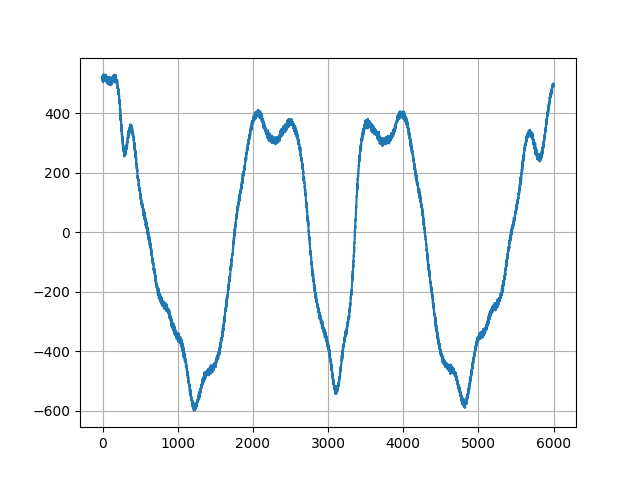

In [23]:
plt.figure()
plt.plot(A_reshaped[0,:])
plt.grid()

In [24]:
samplesPerUpRamp = int(params.samplesPerRamp/2)
print("samplesPerUpRamp = {}".format(samplesPerUpRamp))

samplesPerUpRamp = 3000


In [25]:
upRamp = A_reshaped[0,samplesPerUpRamp:2*samplesPerUpRamp]
downRamp = A_reshaped[0,0:samplesPerUpRamp]

<IPython.core.display.Javascript object>


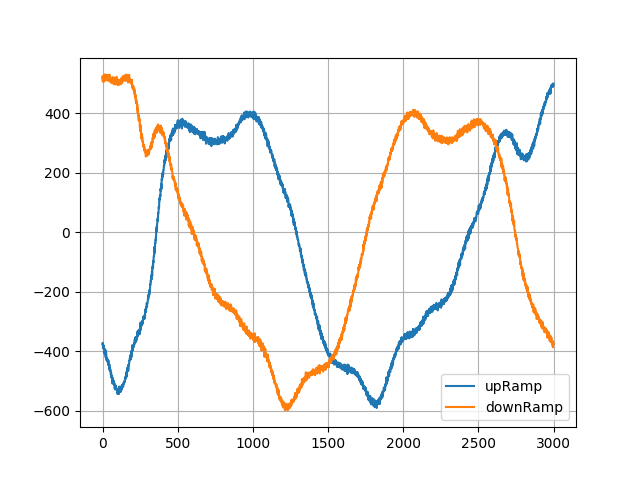

In [26]:
plt.figure()
plt.plot(upRamp, label="upRamp")
plt.plot(downRamp, label="downRamp")
plt.grid()
plt.legend()

In [27]:
fft_upRamp = np.fft.fft(upRamp)
fft_downRamp = np.fft.fft(downRamp)

<IPython.core.display.Javascript object>


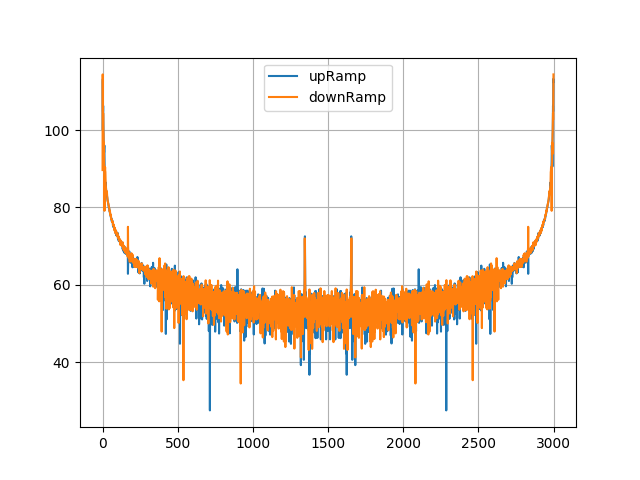

In [28]:
plt.figure()
plt.plot( 20*np.log10(np.abs(fft_upRamp)), label="upRamp" )
plt.plot( 20*np.log10(np.abs(fft_downRamp)), label="downRamp" )
plt.grid()
plt.legend()

In [29]:
delta_f = 1 / (samplesPerUpRamp * T / 2)
delta_r = c / (2 * B)

In [30]:
delta_r

1.0

Set the beginning end the end of the fft to zeros to remove low frequencies

In [39]:
nbPointsToFilter = 30
attenuation = 100

fft_upRamp_filtered = np.zeros(fft_upRamp.shape, dtype=complex)
fft_upRamp_filtered[0:nbPointsToFilter]                   = fft_upRamp[0:nbPointsToFilter] / attenuation
fft_upRamp_filtered[nbPointsToFilter:-nbPointsToFilter+1] = fft_upRamp[nbPointsToFilter:-nbPointsToFilter+1]
fft_upRamp_filtered[-nbPointsToFilter+1:]                 = fft_upRamp[-nbPointsToFilter+1:] / attenuation

fft_downRamp_filtered = np.zeros(fft_downRamp.shape, dtype=complex)
fft_downRamp_filtered[0:nbPointsToFilter]                   = fft_downRamp[0:nbPointsToFilter] / attenuation
fft_downRamp_filtered[nbPointsToFilter:-nbPointsToFilter+1] = fft_downRamp[nbPointsToFilter:-nbPointsToFilter+1]
fft_downRamp_filtered[-nbPointsToFilter+1:]                 = fft_downRamp[-nbPointsToFilter+1:] / attenuation

In [41]:
10e6/3000*nbPointsToFilter

100000.0

<IPython.core.display.Javascript object>


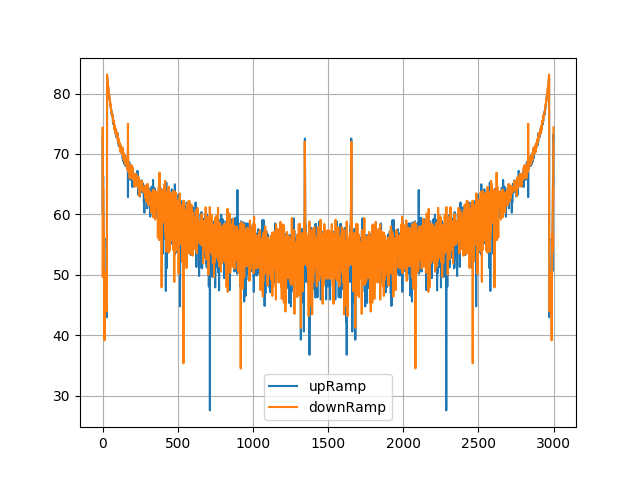

In [42]:
plt.figure()
plt.plot( 20*np.log10(np.abs(fft_upRamp_filtered)), label="upRamp" )
plt.plot( 20*np.log10(np.abs(fft_downRamp_filtered)), label="downRamp" )
plt.grid()
plt.legend()

In [43]:
ffti = np.fft.ifft( fft_upRamp_filtered )
upRamp_filtered = np.real( ffti )

<IPython.core.display.Javascript object>


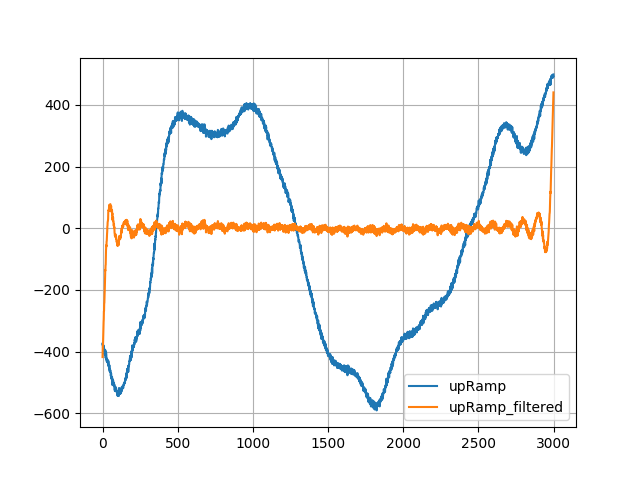

In [45]:
plt.figure()
plt.plot(upRamp, label='upRamp')
plt.plot(upRamp_filtered, label='upRamp_filtered')
plt.grid()
plt.legend()

Conclusion:
When the signal is filtered, the amplitude of the resulting waveform is between -25/+25 counts, corresponding to a value in volts to 


**Input voltage range SMT150**  
**AC coupled option**. 2.4Vp-p (11.5dBm - 50 Ohm) Full scale - AC coupled. 

In [ ]:
2**14/2

# Conclusion
The parameters of the bandpass filter are the following:
Cutoff frequency = 100kHz
